In [4]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Circle, Wedge
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering


Plotting Actual Data

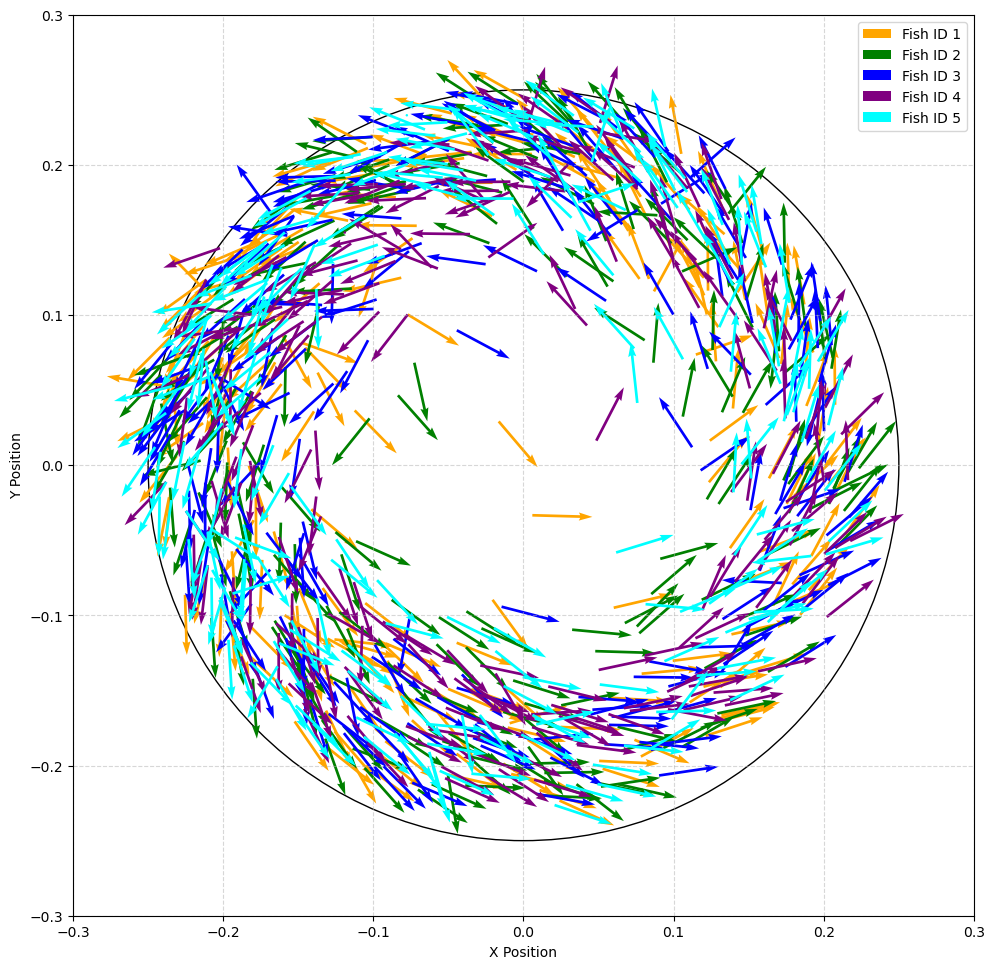

In [ ]:
# Load data
df = pd.read_csv('features.csv')

# Filter for Experiment 151
df_exp = df[df['Experiment_ID'] == 151].copy()

# Define colors for 5 agents (Agent 3 in blue)
agent_colors = {
    1: 'orange',
    2: 'green',
    3: 'blue',
    4: 'purple',
    5: 'cyan'
}

arrow_len = 0.04
fig, ax = plt.subplots(figsize=(10, 10))

# Draw circular tank boundary (radius 0.25)
tank = Circle((0, 0), 0.25, edgecolor='black', facecolor='none', linewidth=1)
ax.add_patch(tank)

# Plot each agent's normalized heading arrows
for aid, color in agent_colors.items():
    df_agent = df_exp[df_exp['Agent_ID'] == aid]
    x = df_agent['X'].values
    y = df_agent['Y'].values
    vx = df_agent['vx'].values
    vy = df_agent['vy'].values
    
    # Normalize velocity vectors - unit length
    norms = np.sqrt(vx**2 + vy**2)
    norms[norms == 0] = 1
    dx = (vx / norms) * arrow_len
    dy = (vy / norms) * arrow_len
    
    ax.quiver(
        x, y, dx, dy,
        angles='xy', scale_units='xy', scale=1,
        color=color, width=0.003, headwidth=3, headlength=5, alpha=1,linewidths=2,
        label=f'Fish ID {aid}'
    )

ax.set_aspect('equal')
ax.set_xlim(-0.3, 0.3)
ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.grid(True, linestyle='--', alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys(), loc='upper right')

for spine in ax.spines.values():
    spine.set_edgecolor('black')

ax.tick_params(axis='both', colors='black')
plt.tight_layout()
plt.savefig("actual_data.svg", format="svg", bbox_inches='tight')
plt.savefig("actual_data.png", format="png", dpi=300, bbox_inches='tight')


plt.show()

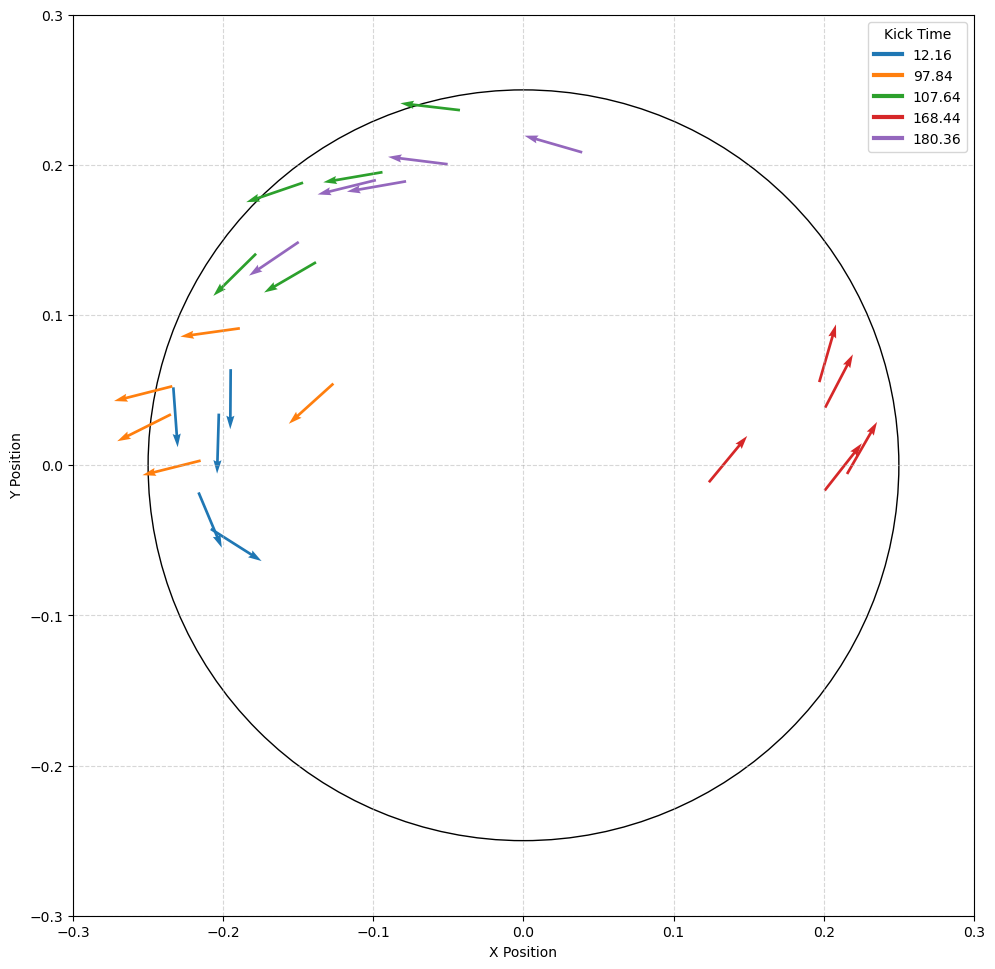

In [6]:
# Load data
df = pd.read_csv('features.csv')

# Filter for Experiment 151
df_exp = df[df['Experiment_ID'] == 151].copy()

# Arrow size
arrow_len = 0.04

# Randomly select 5 unique steps between 1 and 200
unique_kicks = df_exp['Kick_Time'].unique().tolist()
random_kicks = sorted(random.sample(unique_kicks, 5))

# Assign colors to each kick time
cmap = plt.get_cmap('tab10')
step_colors = dict(zip(random_kicks, cmap.colors))

fig, ax = plt.subplots(figsize=(10, 10))
ax.add_patch(Circle((0, 0), 0.25, edgecolor='black', facecolor='none', linewidth=1))

# Plot each kick time
for step_value, color in step_colors.items():
    df_step = df_exp[df_exp['Kick_Time'] == step_value]

    for _, row in df_step.iterrows():
        x, y, vx, vy = row['X'], row['Y'], row['vx'], row['vy']
        norm = np.sqrt(vx**2 + vy**2) or 1
        dx = (vx / norm) * arrow_len
        dy = (vy / norm) * arrow_len

        ax.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1,
                  color=color, width=0.003, headwidth=3, headlength=5)


ax.set_aspect('equal')
ax.set_xlim(-0.30, 0.30)
ax.set_ylim(-0.30, 0.30)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.grid(True, linestyle='--', alpha=0.5)

handles = []
labels = []

for step, color in step_colors.items():
    handle = plt.Line2D([0], [0], color=color, lw=3)
    handles.append(handle)
    labels.append(step)

ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys(), loc='upper right', title = 'Kick Time')
plt.tight_layout()

plt.savefig("data.svg", format="svg", bbox_inches='tight')
plt.savefig("data.png", format="png", dpi=300, bbox_inches='tight')



### Line Plot Generation 100 across all 20 runs 


In [7]:
def generation_filter(folder_path, file_name, bias_flag = True, generation = 99):
    """
    The function extracts normalized weights and its corresponding fitness values for generation 99 for 20 from a CSV file.

    folder_path : str. Path, where the CSV file is located.
    file_name : str. Base name of the CSV file without '.csv' extension.
    bias_flag : bool. If True, include the bias weight.
    generation : Generation filter in the csv file.
    results : list of tuples.
    """

    filename = f'{file_name}.csv'
    filepath = os.path.join(folder_path, file_name)

    # Read CSV 
    with open(filename, newline='') as f:
        reader = csv.DictReader(f)
        file = []
        for row in reader:
            file.append(row)

    results = []

    # Iterate through all 20 runs and extract the weights and their corresponding fitness value
    for run in range(1, 21):
        for row in file:
            if int(row['Run']) == run and int(row['Generation']) == generation:
                fitness = float(row['Best Fitness Value'])
                weights_column = row['Best X Value']
                
                weights_str = weights_column.strip('[]')
                weights_string = weights_str.split()

                weights = []
                for weight in weights_string:
                    weights.append(float(weight))

                # Bias False
                if not bias_flag:
                    weights = weights[:5]

                # Normalize the weights L1
                if np.count_nonzero(weights) > 0:
                    norm = np.linalg.norm(weights, ord = 1)
                    weights = weights / norm

                if not bias_flag:
                    w1, w2, w3, w4, w5 = weights
                    results.append((file_name, run, fitness, w1, w2, w3, w4, w5))

                else:
                    w1, w2, w3, w4, w5, w6 = weights

                    results.append((file_name, run, fitness, w1, w2, w3, w4, w5, w6))
        
    return results

In [ ]:
def plot_weights_per_run(results, file_name):
    """
    Plot weight vectors for each run.
    results: list of tuples (run, fitness, w1, w2, w3, w4, w5, w6)
    file_name : str. name of the file.

    """
    global_min = float('inf')
    global_max = float('-inf')

    for row in results:
        for value in row[3:]:
            if value < global_min:
                 global_min = value
            if value > global_max:
                 global_max = value


    plt.figure(figsize=(10, 10))
    weight_labels = ['w1', 'w2', 'w3', 'w4', 'w5', 'w6']
    x = range(1, 7)  # positions for weights on x-axis

    min_fitness = float('inf')

    # Run with Minimum fitness
    for result in results:
        fitness = result[2]
        if fitness < min_fitness:
            min_fitness = fitness
            best_result = result[3:]
            best_run = result[1]


    for run_data in results:
        run = run_data[1]
        fitness = run_data[2]
        weights = run_data[3:]  # w1 to w6


        if fitness == min_fitness:
            plt.plot(x, weights, marker='o', color = 'black', label=f'Run: {run}')

        else:
            plt.plot(x, weights, marker='o', label=f'Run {run}')
    
    
    plt.xticks(x, weight_labels)
    plt.xlabel('Weights',  fontsize=25)
    plt.ylabel('Weight Values', fontsize=25)
    plt.ylim(global_min - 0.1, global_max + 0.1)
    plt.xlim(0.5, 6.5)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=12)

    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{file_name}_weight_values_across_runs_at_generation_100.svg")
    plt.savefig(f"{file_name}_weight_values_across_runs_at_generation_100.png")

    plt.savefig(f"{file_name}_weight_values_across_runs_at_generation_100.svg", format="svg", bbox_inches='tight')
    plt.savefig(f"{file_name}_weight_values_across_runs_at_generation_100.png", format="png", dpi=300, bbox_inches='tight')


    plt.show()

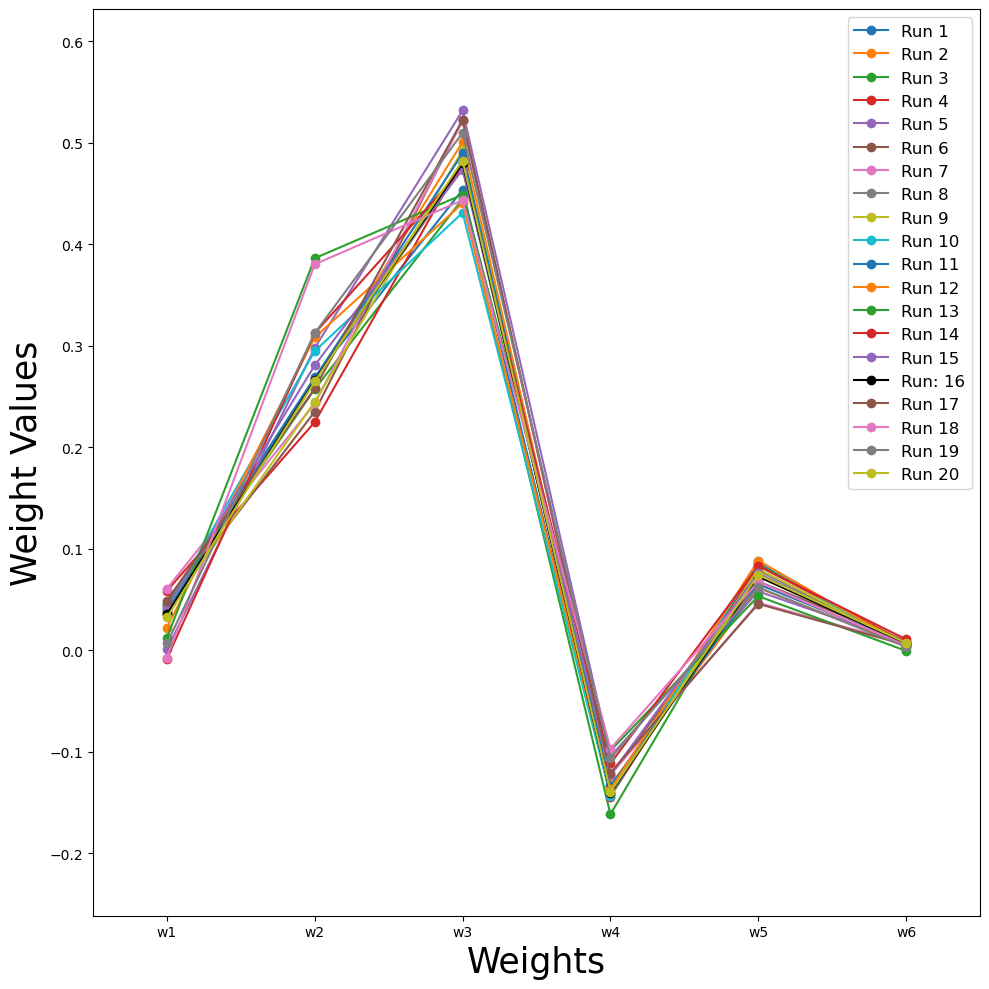

In [9]:
folder_path = r'C:\Users\soori\Desktop\Thesis\Thesis\Test\LossCompare'
file_name = "distance_cosine_results_bias_wall_zone_repulsion_zone"
results = generation_filter(folder_path, file_name, True, generation = 99)
plot_weights_per_run(results, file_name)


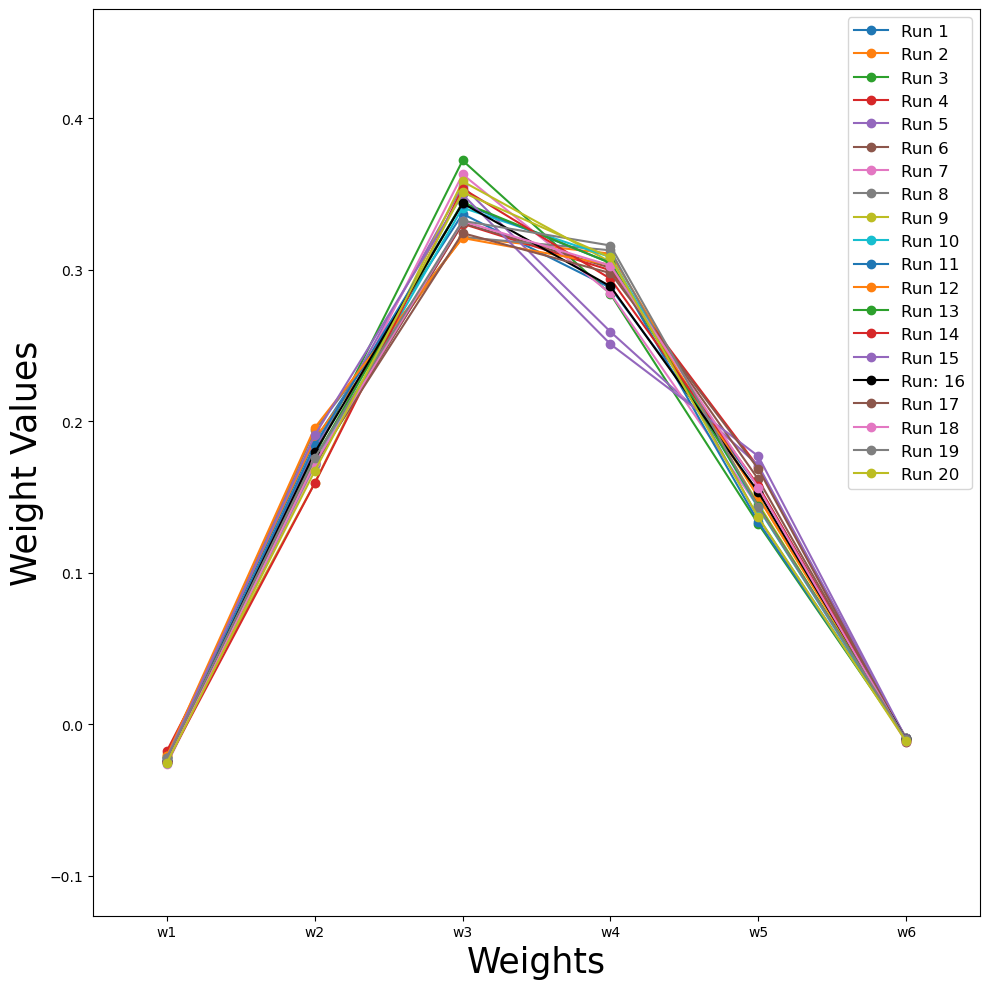

In [10]:
folder_path = r'C:\Users\soori\Desktop\Thesis\Thesis\Test\LossCompare'
file_name = 'orientation_mse_kicktime_results_bias_wall'

results = generation_filter(folder_path, file_name)
plot_weights_per_run(results, file_name)

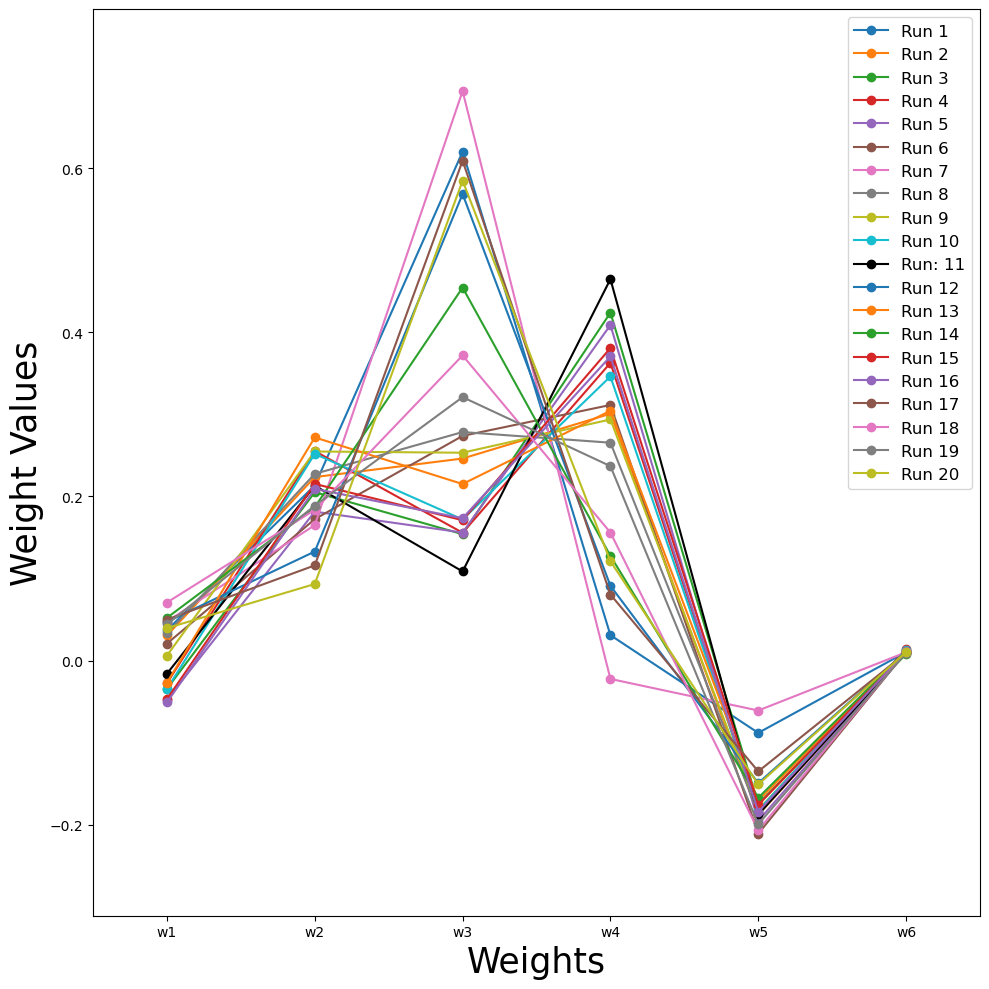

In [11]:
folder_path = r'C:\Users\soori\Desktop\Thesis\Thesis\Test\LossCompare'
file_name = "orientation_cosine_results_bias_wall_zone_repulsion_alignment_zone"
results = generation_filter(folder_path, file_name)
plot_weights_per_run(results, file_name)

### BIAS

In [12]:
def bias_zero(data_dict, kicktime, heading, mode):
    return np.array([0.0, 0.0])

def bias_random(data_dict, kicktime, heading, mode):  
    rand_x = random.uniform(-0.25, 0.25)
    rand_y = random.uniform(-0.25, 0.25)
    return np.array([rand_x, rand_y])

def bias_wall(data_dict, kicktime, heading, mode):    
    return np.array(data_dict[kicktime]['radius_vectors'][0])

def bias_wall_zone(data_dict, kicktime, heading, mode):

    radius = 0.25
    x_wall = data_dict[kicktime]['wall_x'][0]
    y_wall = data_dict[kicktime]['wall_y'][0]

    radial_vector = np.array(data_dict[kicktime]['radius_vectors'][0])
    tangent_vector = np.array(data_dict[kicktime]['tangent_vectors'][0])
    wall_distance = data_dict[kicktime]['wall_distances'][0]

    if mode == 'bias_wall_zone_repulsion_zone':
        repulsion = 0.035
        if wall_distance < repulsion:
            return tangent_vector
        else:
            return np.array([0.0, 0.0])
    
    elif mode == 'bias_wall_zone_alignment_zone':
        align = 0.125
        repulsion = 0
        if wall_distance < align:
            smooth = ((repulsion - wall_distance) / (align - repulsion)) * -1
            return (1 - smooth) * radial_vector + smooth * tangent_vector
        else:
            return np.array([0.0, 0.0])

    elif mode == 'bias_wall_zone_alignment_domain':
        align = radius
        repulsion = 0
        if wall_distance < align:
            smooth = ((repulsion - wall_distance) / (align - repulsion)) * -1
            return (1 - smooth) * radial_vector + smooth * tangent_vector
    
    elif mode == 'bias_wall_zone_repulsion_alignment_zone':
        repulsion = 0.035
        align = 0.125
        if wall_distance < repulsion:
            return tangent_vector
    
        elif wall_distance < align:
            smooth = ((repulsion - wall_distance) / (align - repulsion)) * -1
            return (1 - smooth) * radial_vector + smooth * tangent_vector
        else:
            return np.array([0.0, 0.0])

    elif mode == 'bias_wall_zone_repulsion_alignment_domain':
        repulsion = 0.035
        align = 0.25
        if wall_distance < repulsion:
            return tangent_vector
    
        elif wall_distance < align:
            smooth = ((repulsion - wall_distance) / (align - repulsion)) * -1
            return (1 - smooth) * radial_vector + smooth * tangent_vector

def bias_positive(data_dict, kicktime, heading, mode):
     return np.array([1.0, 1.0])

def bias_negative(data_dict, kicktime, heading, mode):
    return np.array([-1.0, -1.0])

### Objective function

#### Load the data


In [13]:
def load_processed_data(file_path):

    data_dict = {}

    with open(file_path, newline='') as f:
        reader = csv.DictReader(f)
        for row in reader:
            kicktime = float(row['Kick_Time'])
            x = float(row['x'])
            y = float(row['y'])
            vx = float(row['vx'])
            vy = float(row['vy'])
            x_wall = float(row['x_wall'])
            y_wall = float(row['y_wall'])
            tangent_x = float(row['tangent_x'])
            tangent_y = float(row['tangent_y'])
            radius_x = float(row['radius_x'])
            radius_y = float(row['radius_y'])
            wall_distance = float(row['wall_distance'])

            if kicktime not in data_dict:
                data_dict[kicktime] = {
                    'x_coords': [],
                    'y_coords': [],
                    'vx_list': [],
                    'vy_list': [],
                    'wall_vectors': [],
                    'wall_x': [],
                    'wall_y': [],
                    'tangent_vectors': [],
                    'radius_vectors': [],
                    'wall_distances': []
                }

            data_dict[kicktime]['x_coords'].append(x)
            data_dict[kicktime]['y_coords'].append(y)
            data_dict[kicktime]['vx_list'].append(vx)
            data_dict[kicktime]['vy_list'].append(vy)
            data_dict[kicktime]['wall_x'].append(x_wall)
            data_dict[kicktime]['wall_y'].append(y_wall)
            data_dict[kicktime]['tangent_vectors'].append((tangent_x, tangent_y))
            data_dict[kicktime]['radius_vectors'].append((radius_x, radius_y))
            data_dict[kicktime]['wall_distances'].append(wall_distance)

    return data_dict




In [14]:
def extract_min_fitness_value(results):
    '''
    Extract from the csv file the corresponding min fitnessvalue and their respective weights 
    '''    
    min_fitness = float('inf')
    best_result = {}

    for result in results:
        fitness = result[2]
        if fitness < min_fitness:
            min_fitness = fitness
            
            best_result = {
                'file_suffix' : result[0],
                'run' : result[1],
                'fitness' : min_fitness,
                'weights' : result[3:]
            }
    return best_result   

#### Load the sorted velocity

In [15]:
def velocity(file_path):
    kick_times = {}
    with open(file_path) as csv_file:
        csv_reader = csv.DictReader(csv_file, delimiter = ",")

        for row in csv_reader:
            kick_time = float(row["Kick_Time"])
            agent_id = int(row["Agent_ID"])
            vx = float(row["vx"])
            vy = float(row["vy"])
            
            if kick_time not in kick_times:
                kick_times[kick_time] = []
            kick_times[kick_time].append((agent_id, vx, vy))

    return kick_times

### Objective Function

In [16]:
def objective_function(bias_flag, bias_func, velocity_file, data_dict, mode, dim, loss, weights, focal_agent = 3, experiment_id = 151):  
   
    predicted_positions_list = []
    actual_positions_list = []

    if not bias_flag:
        weights = weights[:5]

    if not bias_flag:
        w1, w2, w3, w4, w5 = weights
    else:
        w1, w2, w3, w4, w5, w6 = weights
            
    alpha, beta, gamma, delta, epsilon = w1, w2, w3, w4, w5

    if bias_flag:
        bias = w6
    else:
        bias = 0.0

    weights = np.array([alpha, beta, gamma, delta, epsilon, bias])
        
    if np.count_nonzero(weights) > 0:
        norm = np.linalg.norm(weights, ord = 1)
        weights = weights / norm

    kicktimes = []
    mse_loss = 0.0
    
    for key in velocity_file:
        kicktimes.append(key)

    for agent_id, vx, vy in velocity_file[kicktimes[0]]:
        if agent_id == focal_agent:
            predicted_velocity = np.array([vx, vy])
            break
        
    # inital position at timestep 0 
    first_kicktime = np.min(kicktimes)
    initial_x = data_dict[first_kicktime]['x_coords'][0]  # focal agent is at position 0
    initial_y = data_dict[first_kicktime]['y_coords'][0]

    predicted_position = np.array([initial_x, initial_y])

    for i in range(len(kicktimes)-1):

        kicktime = kicktimes[i]
        next_kicktime = kicktimes[i + 1]
        
        velocities = velocity_file[kicktime]
        next_velocities = velocity_file[next_kicktime]

        updated_velocity = []
           
        for j, (agent_id, vx, vy) in enumerate(next_velocities):
            if j == 0:
                updated_velocity.append((agent_id, predicted_velocity[0], predicted_velocity[1]))
            else:
                updated_velocity.append((agent_id, vx, vy))
           
        vx_total = 0.0
        vy_total = 0.0   
            
        for j, (agent_id, vx, vy) in enumerate(updated_velocity):
            weight = weights[j]
          
            vx_total += vx * weight  
            vy_total += vy * weight 

        if bias_flag:
            bias = bias_func(data_dict, kicktime, predicted_velocity, mode)
            vx_total += bias[0] * weights[5]  # Multiply by the bias agent's weight
            vy_total += bias[1] * weights[5]  # Multiply by the bias agent's weight
        
        predicted_velocity = np.array([vx_total, vy_total]) 

        # update

        if loss == 'cosine':
            actual_velocity = np.array([
            data_dict[next_kicktime]['vx_list'][0],
            data_dict[next_kicktime]['vy_list'][0]
        ])

            dotproduct = np.dot(actual_velocity, predicted_velocity)

            magnitude_a = np.linalg.norm(actual_velocity)
            magnitude_b = np.linalg.norm(predicted_velocity)

            cosine_similarity = dotproduct / (magnitude_a * magnitude_b)

            mse_loss += 1 - np.round(cosine_similarity, 4)
         
        else:

            if loss == 'mse_kicktime':
                # per kicktime mse loss
                updated_x = data_dict[kicktimes[i]]['x_coords'][0]  # focal agent is at position 0
                updated_y = data_dict[kicktimes[i]]['y_coords'][0]

                predicted_position = np.array([updated_x, updated_y])
                predicted_position += predicted_velocity
            
            elif loss == 'mse_trajectory':
                # trajectory mse loss
                predicted_position += predicted_velocity


            actual_position = np.array([
                data_dict[next_kicktime]['x_coords'][0],
                data_dict[next_kicktime]['y_coords'][0]
            ])

            delta_x = predicted_position[0] - actual_position[0]
            delta_y = predicted_position[1] - actual_position[1]
            distance = np.sqrt(delta_x**2 + delta_y**2)

            mse_loss += distance** 2

    return mse_loss

In [17]:
def save_loss_evaluation(evaluation_file):
    '''
    The function evaluate and save loss metrics for each model configurations.
    The function iterates over velocity types, bias configurations, and loss functions.
    It computes the loss values for each combination, and writes the results
    to a CSV file.

    evaluation_file : str. Path to the output CSV file.
    '''
    # loss functions and velocity sorting criteria
    loss_function = ['cosine', 'mse_kicktime', 'mse_trajectory']
    sorted_velocity_types = ['orientation', 'distance', 'bearing']

    # Write the file
    with open(evaluation_file, 'w', newline = '') as f:
        writer = csv.writer(f)
        header = ['Model', 'Fitness EA', 'Weighs', 'Bias_Mode', 'Cosine', 'MSE Kicktime', 'MSE_Trajectory', 'Sorted Velocity Criteria']
        writer.writerow(header) 
        data_dict = load_processed_data("features_151.csv")

        bias_configurations = [
        {
            "name": "bias_wall_zone", 
            "bias_function": bias_wall_zone, 
            "flag": True, 
            "loss": loss_function, 
            "modes": [
                        'bias_wall_zone_repulsion_zone',
                        'bias_wall_zone_alignment_zone',
                        'bias_wall_zone_alignment_domain',
                        'bias_wall_zone_repulsion_alignment_zone',
                        'bias_wall_zone_repulsion_alignment_domain',
                                ]
        },
        {"name": "bias_zero", "bias_function": bias_zero, "flag": False, "loss": loss_function, "modes": [None]},
        {"name": "bias_random", "bias_function": bias_random, "flag": True, "loss": loss_function, "modes": [None]},
        {"name": "bias_wall", "bias_function": bias_wall, "flag": True, "loss": loss_function, "modes": [None]},
        {"name": "bias_positive", "bias_function": bias_positive, "flag": True, "loss": loss_function, "modes": [None]},
        {"name": "bias_negative", "bias_function": bias_negative, "flag": True, "loss": loss_function, "modes": [None]},
        ]

        for types in sorted_velocity_types:
            # Load the corresponding file
            if types == 'orientation':
                velocity_file = velocity("orientation_difference_151.csv")
            elif types == 'distance':
                velocity_file = velocity("distance_difference_151.csv")
            elif types == 'bearing':
                velocity_file = velocity("bearing_difference_151.csv")
            else:
                print('File not found')
                continue
            
            # Test each bias configuration and its modes
            for config in bias_configurations:
                for mode in config['modes']:
                    # Test each loss function in this configuration
                    for loss in config['loss']:

                        folder_path = r"C:\Users\soori\Desktop\Thesis\Thesis\Test\LossCompare"

                        if mode:
                            file_name = f'{types}_{loss}_results_{mode}'
                        else:
                            file_name = f"{types}_{loss}_results_{config['name']}"
                        
                        # EA results 
                        results = generation_filter(folder_path, file_name, config['flag'], generation = 99)
                        best_result = extract_min_fitness_value(results)
                        
                        # Extract the best weight and its fitness value
                        weights = best_result['weights']
                        fitness = best_result['fitness']
                        model_name = best_result['file_suffix']

                        # Compute losses for all loss functions using objective_function
                        loss_dct = {}
                        for loss in loss_function:

                            loss_value = objective_function(
                                bias_flag = config['flag'],
                                bias_func = config['bias_function'],
                                velocity_file = velocity_file,
                                data_dict = data_dict,
                                mode = mode, 
                                dim = 6,
                                loss =  loss,
                                weights = weights,
                                focal_agent = 3,
                                experiment_id = 151
                            )

                            loss_dct[loss] = loss_value

                        mode_name = f"{config['name']}_{mode}"

                        writer.writerow([model_name, fitness, weights, mode_name, loss_dct['cosine'], loss_dct['mse_kicktime'], loss_dct['mse_trajectory'], types])


In [18]:
# evaluate = save_loss_evaluation('evaluation_loss.csv')

### Collect Data - Boxplot

In [19]:
def collect(folder_path):
    """
    Extracts best fitness values grouped by velocity for a given loss type.
    """
    cosine_dict = {'orientation': [], 'distance': [], 'bearing': []}
    mse_trajectory_dict = {'orientation': [], 'distance': [], 'bearing': []}
    mse_kicktime_dict = {'orientation': [], 'distance': [], 'bearing': []}

    velocity_types = ['orientation', 'distance', 'bearing']
    loss_function = ['cosine', 'mse_kicktime', 'mse_trajectory']

    configurations = [
        {
            "name": "bias_wall_zone", 
            "bias_function": bias_wall_zone, 
            "flag": True, 
            "loss": loss_function, 
            "modes": [
                        'bias_wall_zone_repulsion_zone',
                        'bias_wall_zone_alignment_zone',
                        'bias_wall_zone_alignment_domain',
                        'bias_wall_zone_repulsion_alignment_zone',
                        'bias_wall_zone_repulsion_alignment_domain',
                                ]
        },
        {"name": "bias_zero", "bias_function": bias_zero, "flag": False, "loss": loss_function, "modes": [None]},
        {"name": "bias_random", "bias_function": bias_random, "flag": True, "loss": loss_function, "modes": [None]},
        {"name": "bias_wall", "bias_function": bias_wall, "flag": True, "loss": loss_function, "modes": [None]},
        {"name": "bias_positive", "bias_function": bias_positive, "flag": True, "loss": loss_function, "modes": [None]},
        {"name": "bias_negative", "bias_function": bias_negative, "flag": True, "loss": loss_function, "modes": [None]},
        ]

    for velocity in velocity_types:
        for config in configurations:
            for mode in config['modes']:
                for loss in loss_function:

                    if mode:
                        file_name = f'{velocity}_{loss}_results_{mode}'
                    else:
                        file_name = f"{velocity}_{loss}_results_{config['name']}"
        
                    results = generation_filter(folder_path, file_name, config['flag'], generation = 99)
                    best_result = extract_min_fitness_value(results)

                    if loss == 'cosine':
                        cosine = best_result.get('fitness')
                        cosine_dict[velocity].append(cosine)
                    elif loss == 'mse_trajectory':
                        mse_trajectory = best_result.get('fitness')
                        mse_trajectory_dict[velocity].append(mse_trajectory)
                    elif loss == 'mse_kicktime':
                        mse_kicktime = best_result.get('fitness')
                        mse_kicktime_dict[velocity].append(mse_kicktime)

                    else:
                        print('Loss not found')
                   
    return cosine_dict, mse_kicktime_dict, mse_trajectory_dict

In [20]:
def compare_boxplot(cosine_dict, mse_kicktime_dict, mse_trajectory_dict):
    """
    result_dict = {'orientation': [], 'distance': [], 'bearing': []}
    The function creates 3 boxplot for each loss function.
    
    """
    labels = ['Orientation', 'Distance', 'Bearing'] 

    fig, axs = plt.subplots(1, 3, figsize=(10, 10))

    cosine = []
    for label in labels:
        cosine.append(cosine_dict[label.lower()])

    mse_kicktime = []
    for label in labels:
        mse_kicktime.append(mse_kicktime_dict[label.lower()])

    mse_trajectory = []
    for label in labels:
        mse_trajectory.append(mse_trajectory_dict[label.lower()])

    bpc = axs[0].boxplot(cosine, patch_artist = True, showmeans = True) 
    axs[0].set_title('EA Cosine')
    axs[0].set_ylabel('Fitness Value')
    axs[0].set_xticklabels(labels)
    axs[0].grid(True, linestyle='--', alpha=0.5)

    bpk = axs[1].boxplot(mse_kicktime, patch_artist = True, showmeans = True) 
    axs[1].set_title("EA MSE Kicktime")
    axs[1].set_ylabel('Fitness Value')
    axs[1].set_xticklabels(labels)
    axs[1].grid(True, linestyle='--', alpha=0.5)

    bpt =axs[2].boxplot(mse_trajectory, patch_artist = True, showmeans = True) 
    axs[2].set_title('EA MSE Trajectory')
    axs[2].set_ylabel('Fitness Value')
    axs[2].set_xticklabels(labels)
    axs[2].grid(True, linestyle='--', alpha=0.5)

    axs[0].set_xticklabels(labels, rotation=45, ha='right')
    axs[1].set_xticklabels(labels, rotation=45, ha='right')
    axs[2].set_xticklabels(labels, rotation=45, ha='right')
   
    plt.tight_layout()
    plt.savefig('boxplot.svg')
    
    plt.show()

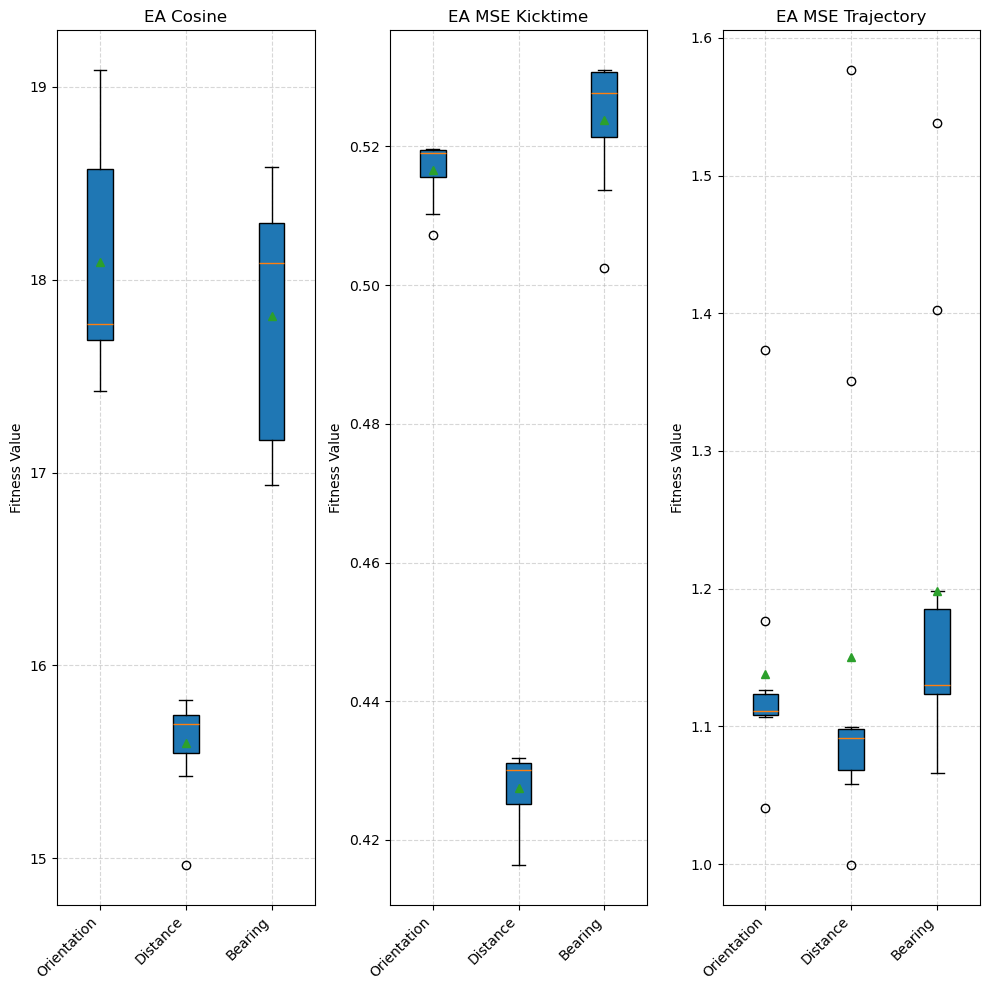

In [21]:
folder_path = r"C:\Users\soori\Desktop\Thesis\Thesis\Test\LossCompare"
cosine_dict, mse_kicktime_dict, mse_trajectory_dict = collect(folder_path)

compare_boxplot(cosine_dict, mse_kicktime_dict, mse_trajectory_dict)

Predict

In [22]:
def predict(bias_flag, bias_func, velocity_file, data_dict, mode, dim, loss, weights, focal_agent = 3, experiment_id = 151):  
    '''
    The function generate predicted velocities and positions for a focal fish per kick time.
    bias_flag : Bool. If True bias wall will be computed.
    bias_func : Function to compute bias vector.
    velocity_file : Dict. Maps each kicktime to lists of (agent_id, vx, vy) tuples.
    data_dict : Dict. Maps Kicktime to 'x_coords' and 'y_coords'.
    mode : str. None if bias wall is not used, else string to configure the bias wall.
    dim : Int. Focal fish and bias vector, input 6 velocity vector.
    loss : Str. Loss type: cosine, mse_kicktime, or mse_trajectory.
    weights : List. np.array of weights - scaled for the velocity.
    focal_agent : Int.ID of the focal fish.
    experiment_id : Int. ID of the experiment.
    returns: predicted_velocity_list : list of np.ndarray. List of Predicted velocity vectors for the focal agent.
    predicted_position_list : list of np.ndarray. List of predicted position vectors for the focal agent.
    '''
    predicted_velocity_list = []
    predicted_position_list = []
    
    # if not bias_flag = not False = True - ignore 6 weight
    if not bias_flag:
        weights = weights[:5]
        print(f'weights 5 base case: {weights}')

    if not bias_flag:
        w1, w2, w3, w4, w5 = weights
        # print(w1,w2,w3,w4,w5)
    else:
        w1, w2, w3, w4, w5, w6 = weights
        # print(w1,w2,w3,w4,w5,w6)
            
    alpha, beta, gamma, delta, epsilon = w1, w2, w3, w4, w5

    if bias_flag:
        bias = w6
    else:
        bias = 0.0

    weights = np.array([alpha, beta, gamma, delta, epsilon, bias])
        
    # Normalize L1
    if np.count_nonzero(weights) > 0:
        norm = np.linalg.norm(weights, ord = 1)
        weights = weights / norm
        
    kicktimes = []
    
    for key in velocity_file:
        kicktimes.append(key)
    
    # Initialize predicted velocity as the focal agent's first velocity from the actual data
    for agent_id, vx, vy in velocity_file[kicktimes[0]]:
        if agent_id == focal_agent:
            predicted_velocity = np.array([vx, vy])
            break

    # initalize position at timestep 0 
    first_kicktime = np.min(kicktimes)
    initial_x = data_dict[first_kicktime]['x_coords'][0]  # focal agent is at position 0
    initial_y = data_dict[first_kicktime]['y_coords'][0]

    predicted_position = np.array([initial_x, initial_y])
    # print(predicted_position)

    for i in range(len(kicktimes)-1):
        kicktime = kicktimes[i]
        next_kicktime = kicktimes[i + 1]
        
        # velocity lists at current and next times
        velocities = velocity_file[kicktime]
        next_velocities = velocity_file[next_kicktime]
           
        updated_velocity = []
        for j, (agent_id, vx, vy) in enumerate(next_velocities):
            if j == 0:
                updated_velocity.append((agent_id, predicted_velocity[0], predicted_velocity[1]))
            else:
                updated_velocity.append((agent_id, vx, vy))

        vx_total = 0.0
        vy_total = 0.0  

        # replace focal fish data with predicted_velocity
        for j, (agent_id, vx, vy) in enumerate(updated_velocity):
            weight = weights[j]
            vx_total += vx * weight  
            vy_total += vy * weight 
        
        # Bias
        if bias_flag:
            bias = bias_func(data_dict, kicktime, predicted_velocity, mode)
            vx_total += bias[0] * weights[5]  # Multiply by the bias agent's weight
            vy_total += bias[1] * weights[5]  # Multiply by the bias agent's weight
        
        # update
        predicted_velocity = np.array([vx_total, vy_total]) 

        # loss
        if loss == 'cosine':
            updated_x = data_dict[kicktimes[i]]['x_coords'][0]  # focal agent is at position 0
            updated_y = data_dict[kicktimes[i]]['y_coords'][0]

            predicted_position = np.array([updated_x, updated_y])
            predicted_position += predicted_velocity
         
        else:

            if loss == 'mse_kicktime':
                updated_x = data_dict[kicktimes[i]]['x_coords'][0]  # focal agent is at position 0
                updated_y = data_dict[kicktimes[i]]['y_coords'][0]

                predicted_position = np.array([updated_x, updated_y])
                predicted_position += predicted_velocity
            
            elif loss == 'mse_trajectory':
                predicted_position += predicted_velocity

        predicted_velocity_list.append(predicted_velocity)
        predicted_position_list.append(predicted_position)

    return predicted_velocity_list

In [23]:
def velocity(file_path):
    kick_times = {}
    with open(file_path) as csv_file:
        csv_reader = csv.DictReader(csv_file, delimiter = ",")

        for row in csv_reader:
            kick_time = float(row["Kick_Time"])
            agent_id = int(row["Agent_ID"])
            vx = float(row["vx"])
            vy = float(row["vy"])
            
            if kick_time not in kick_times:
                kick_times[kick_time] = []
            kick_times[kick_time].append((agent_id, vx, vy))

    return kick_times

In [24]:
def load_data(filepath, data_dict, prediction, focal_agent = 3, experiment_id = 151):
    """
    The function loads the csv data of agent positions, velocities, adds predicted velocities.
    filepath: str. Path to the file.
    data_dict: Dict. Maps actual positions for each kick time.
    prediction: Dict. Predicted velocity vectors for the focal agent at kick time.
    focal_agent: int. ID of the focal fish= 3. 
    experiment_id = 151. int. Experinment ID of the current data.
    return: plot_data : list of dict.
    """
    kicktimes = {}

    # Read the file.
    with open(filepath, newline='') as csvfile:
        reader = csv.DictReader(csvfile)

        for row in reader:
            if int(row['Experiment_ID']) != experiment_id:
                continue
            # Extract the data
            kicktime = float(row['Kick_Time'])
            agent_id = int(row['Agent_ID'])
            x = float(row['X'])
            y = float(row['Y'])
            vx = float(row['vx'])
            vy = float(row['vy'])

            if kicktime not in kicktimes:
                kicktimes[kicktime] = []
            kicktimes[kicktime].append((agent_id, x, y, vx, vy))

    plot_data = []

    sorted_times = sorted(kicktimes.keys())

    for i in range(len(sorted_times) - 1):
        kicktime = sorted_times[i]

        for k in kicktimes[kicktime]:

            if k[0] == focal_agent:
                plot_data.append({
                    "kicktime": kicktime,
                    "x": k[1],
                    "y": k[2],
                    "actual_vx":k[3],
                    "actual_vy": k[4],
                    "predicted_vx": prediction[i][0],
                    "predicted_vy" :  prediction[i][1]
                })
    
    return plot_data



In [25]:
# data_dict = load_processed_data("features_151.csv")
# loss = 'mse_kicktime'
# velocity_file = velocity("distance_difference_151.csv")
# weights = [0.004469302918657105, 0.46998196740288734, 0.4030203231341278, 0.0830950912493724, -0.03013021024300225, -0.009303105051953192]
# focal_agent = 3
# experiment_id = 151

# prediction = predict(
#     bias_flag =True, 
#     bias_func = bias_wall, 
#     velocity_file = velocity_file, 
#     data_dict = data_dict, 
#     mode = [None], 
#     dim = 6, 
#     loss = loss, 
#     weights = weights, 
#     focal_agent = focal_agent, 
#     experiment_id = experiment_id)  

# load = load_data('features.csv', velocity_file, prediction)


### Plot Trajectory

In [26]:
def plot_trajectories(plot_data):
    '''Plot actual vs predicted trajectories for a focal agent - kick times.'''
    actual_x, actual_y = [], []
    pred_x, pred_y = [], []

    x = plot_data[0]['x']
    y = plot_data[0]['y']
    x_pred = x
    y_pred = y

    actual_x.append(x)
    actual_y.append(y)
    pred_x.append(x_pred)
    pred_y.append(y_pred)

    for data in plot_data:
        x += data['actual_vx']
        y += data['actual_vy']
        x_pred += data['predicted_vx']
        y_pred += data['predicted_vy']
        actual_x.append(x)
        actual_y.append(y)
        pred_x.append(x_pred)
        pred_y.append(y_pred)

    fig, ax = plt.subplots(figsize=(10, 10))

    # Fading actual trajectory
    for i in range(1, len(actual_x)):
        alpha = i / len(actual_x)
        ax.plot(actual_x[i-1:i+1], actual_y[i-1:i+1],
                color='blue', alpha=alpha, linewidth=2, linestyle = ':')

    # Fading predicted trajectory
    for i in range(1, len(pred_x)):
        alpha = i / len(pred_x)
        ax.plot(pred_x[i-1:i+1], pred_y[i-1:i+1],
                color='red', alpha=alpha, linewidth=2, linestyle = ':')

    # Start and end
    ax.plot(actual_x[0], actual_y[0], 'ko', label='Start')
    ax.plot(actual_x[-1], actual_y[-1], 'b^', label='End Actual')
    ax.plot(pred_x[-1], pred_y[-1], 'r^', label='End Predicted')

    # Tank wall
    circle = Circle((0, 0), 0.25, color='black', fill=False, linewidth=1)
    ax.add_patch(circle)
    ax.set_title('Actual vs Predicted Trajectory')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.axis('equal')
    ax.grid(True, linestyle='--', alpha=0.5)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys(), loc='upper right')
    plt.tight_layout()
    plt.savefig("trajectory.svg", format="svg", bbox_inches='tight')
    plt.savefig("trajectory.png", format="png", dpi=300, bbox_inches='tight')


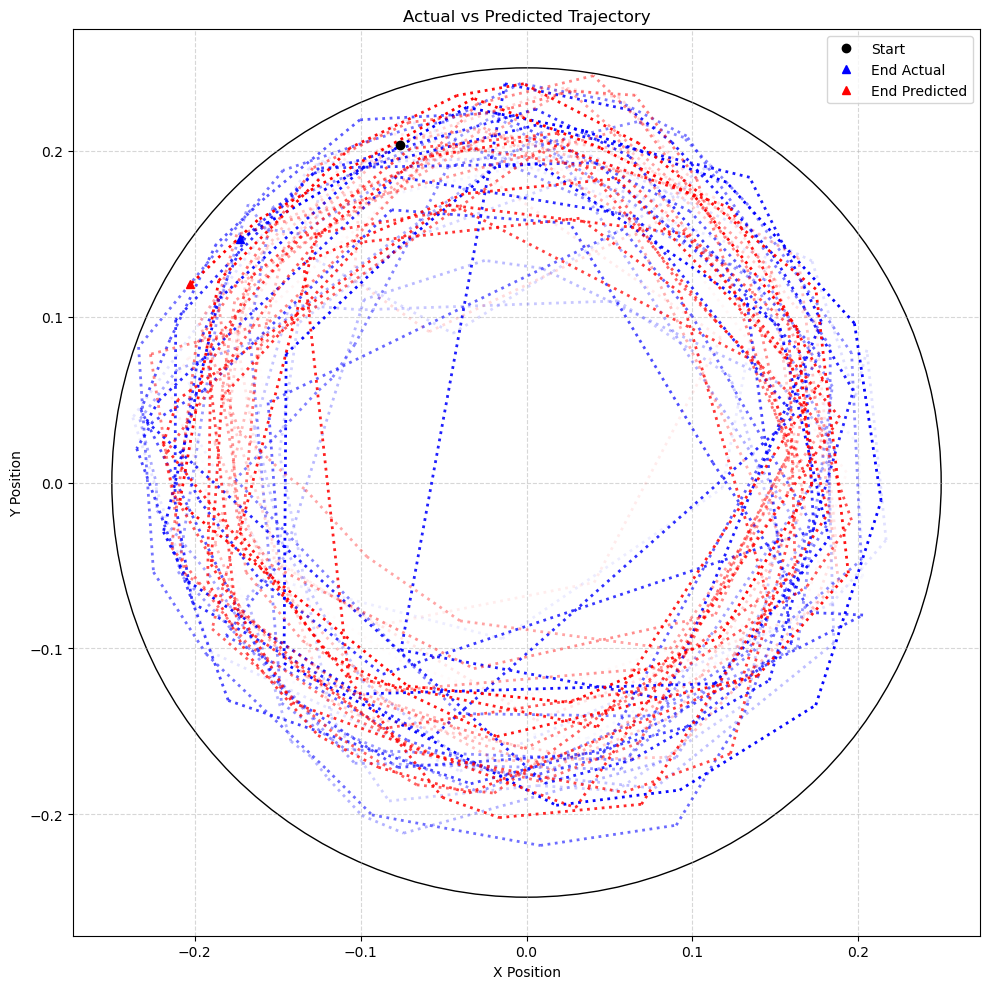

In [27]:
data_dict = load_processed_data("features_151.csv")
loss = 'mse_trajectory'
velocity_file = velocity("distance_difference_151.csv")
weights = [-0.0001775297621391969, 0.2532934508276476, 0.3470828862166679, 0.2009170398251291, 0.19719968330415324, -0.0013294100642629533]
focal_agent = 3
experiment_id = 151

prediction = predict(
    bias_flag =True, 
    bias_func = bias_wall_zone, 
    velocity_file = velocity_file, 
    data_dict = data_dict, 
    mode = 'bias_wall_zone_alignment_zone', 
    dim = 6, 
    loss = loss, 
    weights = weights, 
    focal_agent = focal_agent, 
    experiment_id = experiment_id)  

data = load_data('features.csv', data_dict, prediction )
plot_trajectories(data)

### Plot Kicktime in a Circle

In [28]:
def predicted_veloctity(load):
    '''Plot actual vs predicted trajectories for a focal agent - kick times.'''
    kicktimes = []
    x_coords = []
    y_coords = []
    actual_vx = []
    actual_vy = []
    predicted_vx = []
    predicted_vy = []


    for entry in load:
        kicktimes.append(entry['kicktime'])
        x_coords.append(entry['x'])
        y_coords.append(entry['y'])
        actual_vx.append(entry['actual_vx'])
        actual_vy.append(entry['actual_vy'])
        predicted_vx.append(entry['predicted_vx'])
        predicted_vy.append(entry['predicted_vy'])

    plt.figure(figsize=(10,10))
    plt.quiver(x_coords, y_coords, predicted_vx, predicted_vy, color='red', label='Predicted')
    plt.quiver(x_coords, y_coords, actual_vx, actual_vy, color='blue', label='Actual')

    circle_center = (0, 0)
    circle_radius = 0.25

    # Create and add the circle
    circle = Circle(circle_center, circle_radius, color='black', fill=False)
    plt.gca().add_patch(circle)

    plt.gca().set_aspect('equal', adjustable='box')

    # Formatting
    ax.set_aspect('equal')
    plt.xlim(-0.30, 0.30)
    plt.ylim(-0.30, 0.30)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    # ax.set_title(f'Distance')
    ax.grid(True, linestyle='--', alpha=0.5)

    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    ax.tick_params(axis='both', colors='black')  # ticks and tick labels

    plt.tight_layout()


    plt.savefig(f"actual_vs_predicted_velocities_mse_kicktime.png")
    plt.savefig(f"actual_vs_predicted_velocities_mse_kicktime.pdf")
    plt.savefig(f"actual_vs_predicted_velocities_mse_kicktime.svg")
    plt.show()

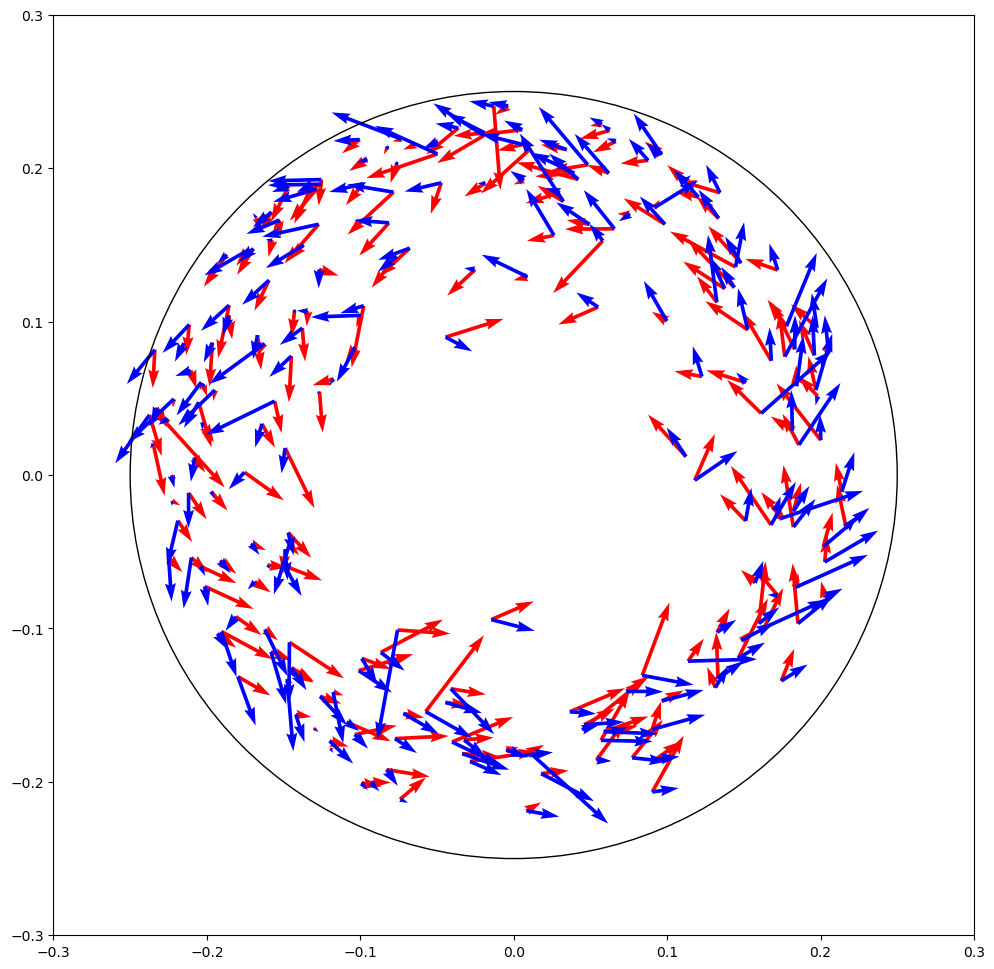

In [29]:
# distance_mse_kicktime_results_bias_wall

loss = 'mse_kicktime'
velocity_file = velocity("distance_difference_151.csv")
weights = [0.004469302918657105, 0.46998196740288734, 0.4030203231341278, 0.0830950912493724, -0.03013021024300225, -0.009303105051953192]

focal_agent = 3
experiment_id = 151

prediction = predict(
    bias_flag =True, 
    bias_func = bias_wall, 
    velocity_file = velocity_file, 
    data_dict = data_dict, 
    mode = [None], 
    dim = 6, 
    loss = loss, 
    weights = weights, 
    focal_agent = focal_agent, 
    experiment_id = experiment_id)  

    

load = load_data('features.csv', velocity_file, prediction)
predicted_veloctity(load)


In [30]:
def predicted_veloctity(load):
    '''Plot actual vs predicted trajectories for a focal agent - kick times.'''

    kicktimes = []
    x_coords = []
    y_coords = []
    actual_vx = []
    actual_vy = []
    predicted_vx = []
    predicted_vy = []


    for entry in load:
        kicktimes.append(entry['kicktime'])
        x_coords.append(entry['x'])
        y_coords.append(entry['y'])
        actual_vx.append(entry['actual_vx'])
        actual_vy.append(entry['actual_vy'])
        predicted_vx.append(entry['predicted_vx'])
        predicted_vy.append(entry['predicted_vy'])

    plt.figure(figsize=(10,10))
    plt.quiver(x_coords, y_coords, predicted_vx, predicted_vy, color='red', label='Predicted')
    plt.quiver(x_coords, y_coords, actual_vx, actual_vy, color='blue', label='Actual')

    circle_center = (0, 0)
    circle_radius = 0.25

    # Create and add the circle
    circle = Circle(circle_center, circle_radius, color='black', fill=False)
    plt.gca().add_patch(circle)

    # # Ensure the aspect ratio is equal for a proper circle
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.legend()
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('Actual vs Predicted Velocities')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [31]:
loss = 'cosine'
velocity_file = velocity("distance_difference_151.csv")
weights = [0.035154736715024976, 0.26563354131715866, 0.4794856861530686, -0.1409696170159797, 0.07236079432123596, 0.006395624477532218]

focal_agent = 3
experiment_id = 151

prediction = predict(
    bias_flag =True, 
    bias_func = bias_wall_zone, 
    velocity_file = velocity_file, 
    data_dict = data_dict, 
    mode = 'bias_wall_zone_repulsion_zone', 
    dim = 6, 
    loss = loss, 
    weights = weights, 
    focal_agent = focal_agent, 
    experiment_id = experiment_id) 


In [32]:
def standardize(data):
    """Return z-score scaled data as numpy array."""
    data = np.array(data).reshape(-1, 1)
    return StandardScaler().fit_transform(data).flatten()

### PCA Cosine

In [33]:
file_path = "distance_mse_kicktime_results_bias_wall"
results = generation_filter(folder_path, file_name, True, generation = 99)
best_result = extract_min_fitness_value(results)


In [34]:
def pca(results, file_name):
    """
    The function does PCA on weight vectors across runs and visualize clustering.

    """

    weights = []
    runs = []
    for result in results:
        weights.append(result[3:])
        runs.append(f'R{result[1]}')

    weights_np = np.array(weights)
    
    # Standardize the weights before PCA
    scaled_weights = StandardScaler().fit_transform(weights_np)

    # Reduce dimension to 2 with PCA
    pca_model = PCA(n_components = 2).fit_transform(scaled_weights)

    # Plot PCA
    plt.figure(figsize=(10, 10))
    ax.scatter(pca_model[:, 0], pca_model[:, 1], color='steelblue', s=40)

    for i, label in enumerate(runs):
        plt.text(pca_model[i, 0], pca_model[i, 1], label, fontsize=9)
    
    cluster = AgglomerativeClustering(n_clusters=3, linkage='ward')  
    labels = cluster.fit_predict(pca_model)

    sns.scatterplot(x=pca_model[:, 0], y=pca_model[:, 1], hue=labels, palette='Set2', s=60)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA of Weights - Agglomerative Clustering', fontsize = 25)
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{file_name}_PCA_weights.png")
    plt.savefig(f"{file_name}_PCA_weights.svg")
    plt.savefig(f"{file_name}_PCA_weights.pdf")
    plt.show()

In [35]:
file_path = "distance_cosine_results_bias_wall_zone_repulsion_zone"
results = generation_filter(folder_path, file_name, True, generation = 99)
best_result = extract_min_fitness_value(results)

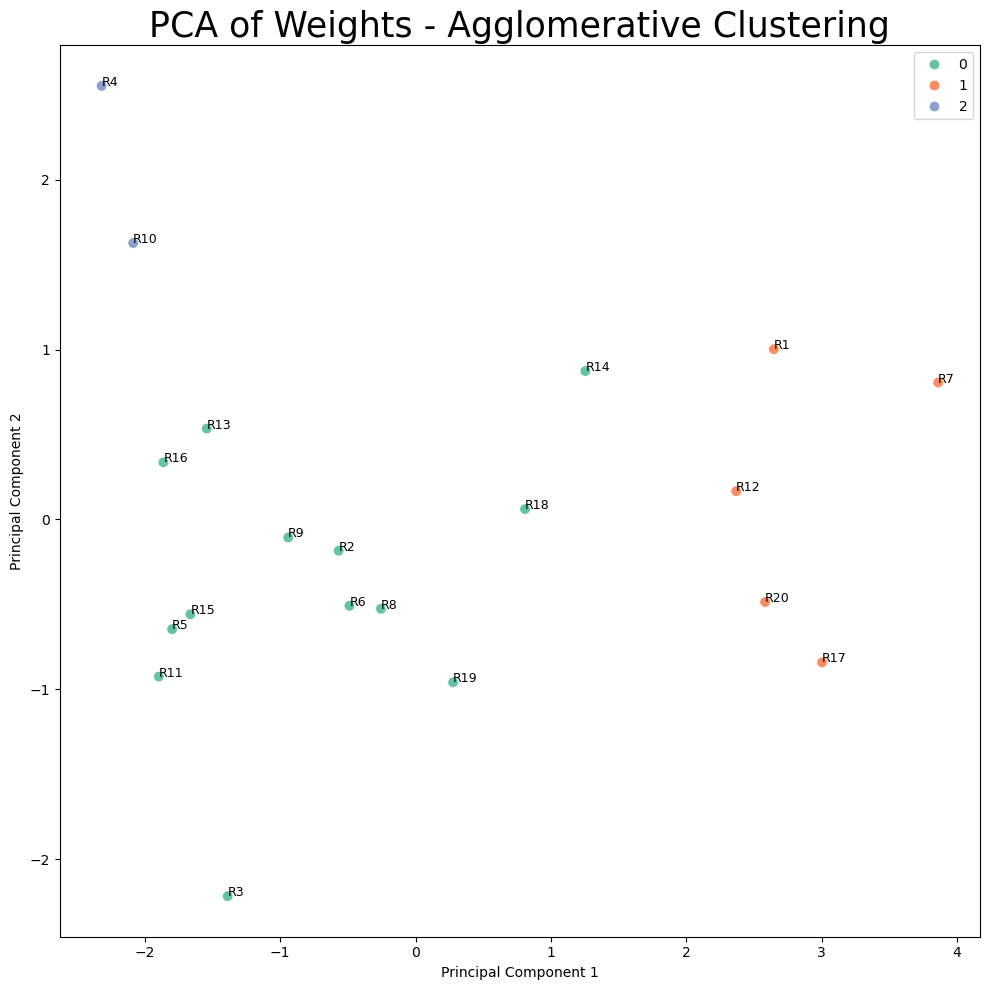

In [36]:
pca(results, file_name)

In [37]:
weights = []
runs = []
for result in results:
    weights.append(result[3:])
    runs.append(f'R{result[1]}')

weights_np = np.array(weights)

# 1. Standardize
scaled = StandardScaler().fit_transform(weights_np)

# 2. PCA
pca = PCA(n_components=2)
scores = pca.fit_transform(scaled) 

# 3. Extract loadings
loadings = pca.components_ 

df_loadings = pd.DataFrame(
    loadings,
    index=['PC1','PC2'],
    columns=['w1','w2','w3','w4','w5','bias']
)
print(df_loadings)


           w1        w2        w3        w4        w5      bias
PC1  0.426664 -0.374113  0.513750 -0.497973  0.381424 -0.143518
PC2 -0.017579  0.346208  0.114958 -0.227437  0.235377  0.871485


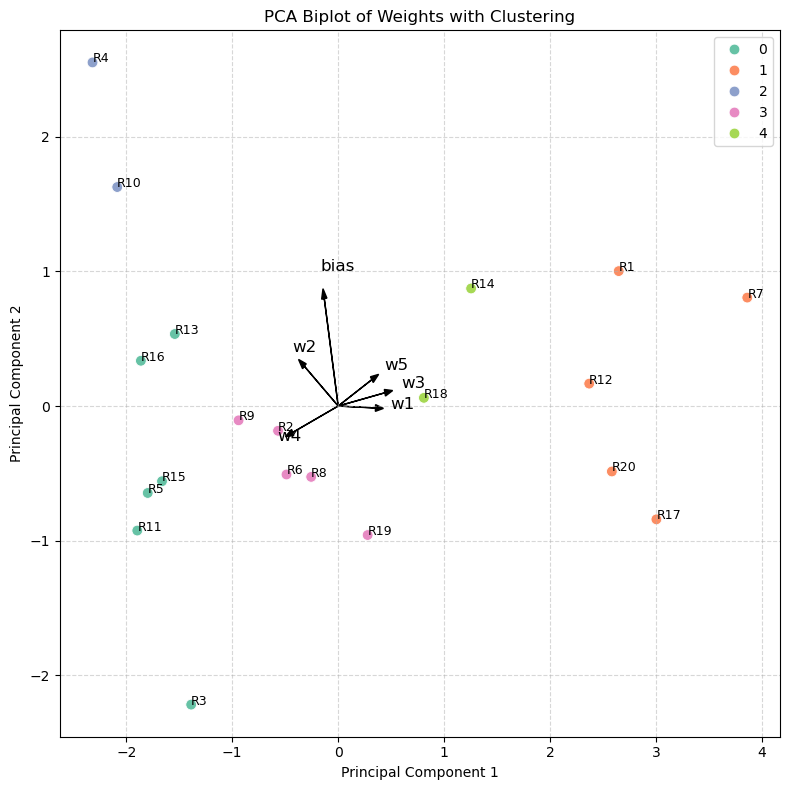

In [38]:
# Draw vectors to understand PCA better

# 1. Extract weights/runs
weights = []
runs = []
for res in results:
    weight_vector = res[3:]
    weights.append(weight_vector)
    runs.append('R{}'.format(res[1]))  

W = np.vstack(weights)

# 2. Standardize & PCA
scaled = StandardScaler().fit_transform(W)
pca    = PCA(n_components=2)
scores = pca.fit_transform(scaled)
loadings = pca.components_.T  # shape (features=6, 2)

# 3. Clustering
labels = AgglomerativeClustering(n_clusters=5, linkage='ward').fit_predict(scores)

# 4. Plot
plt.figure(figsize=(8,8))
ax = plt.gca()

# Scatter with clusters
sns.scatterplot(x=scores[:,0], y=scores[:,1], hue=labels, palette='Set2', s=60, ax=ax)

for i, label in enumerate(runs):
    ax.text(scores[i,0], scores[i,1], label, fontsize=9)

# Draw loading vectors
feature_names = ['w1','w2','w3','w4','w5','bias']
for i, (lx, ly) in enumerate(loadings):
    ax.arrow(0, 0, lx, ly, head_width=0.05, length_includes_head=True, color='black')
    ax.text(lx*1.15, ly*1.15, feature_names[i], color='black', fontsize=12)

# Final touches
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA Biplot of Weights with Clustering')
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Processing: distance_cosine_results_bias_wall_zone_repulsion_zone


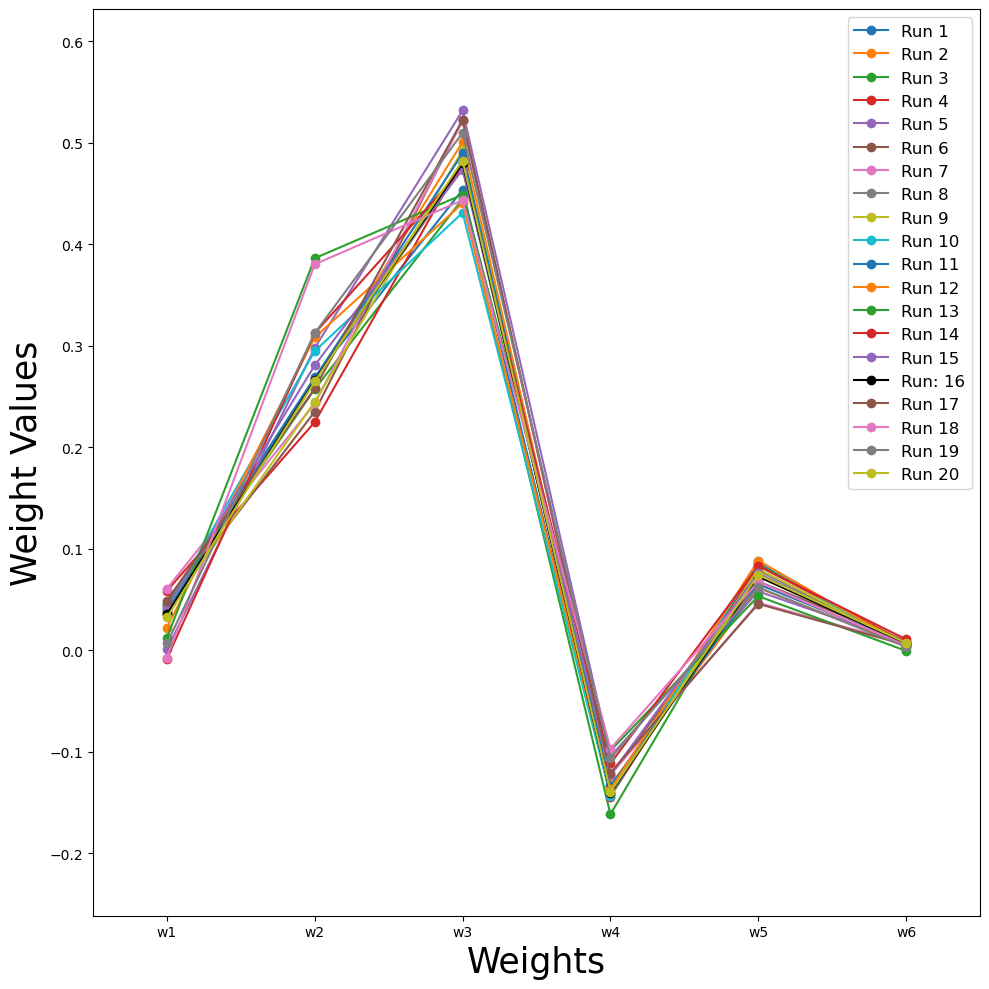

           w1        w2        w3        w4        w5      bias
PC1 -0.487342  0.562530 -0.071310  0.531145 -0.253824 -0.307296
PC2  0.084745 -0.246918  0.695994  0.276616 -0.573799  0.204157
Processing: distance_mse_kicktime_results_bias_wall


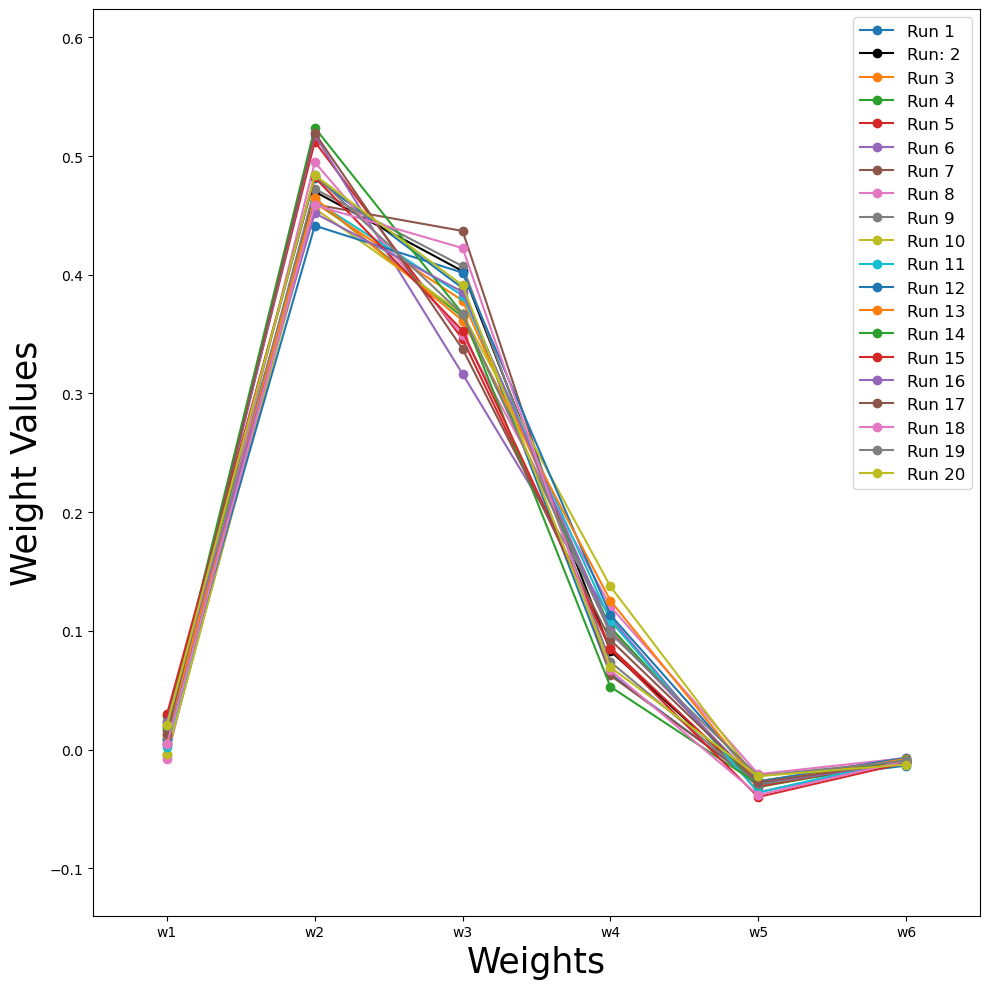

           w1        w2        w3        w4        w5      bias
PC1 -0.540651 -0.360961  0.150507  0.451610  0.191844  0.560353
PC2 -0.023497 -0.500364  0.734231 -0.412314 -0.086506 -0.180282


In [ ]:
file_names = ["distance_cosine_results_bias_wall_zone_repulsion_zone", "distance_mse_kicktime_results_bias_wall"]
folder_path = r'C:\Users\soori\Desktop\Thesis\Thesis\Test\LossCompare'

for file_name in file_names:
    print(f'Processing: {file_name}')
    results = generation_filter(folder_path, file_name)
    plot_weights_per_run(results, file_name)

    weights = []
    runs = []
    for result in results:
        weights.append(result[3:])
        runs.append(f'R{result[1]}')

    weights_np = np.array(weights)

    # 1. Standardize
    scaled = StandardScaler().fit_transform(weights_np)
    
    pca = PCA(n_components=2)
    scores = pca.fit_transform(scaled)

    # 3. Extract loadings
    loadings = pca.components_

    import pandas as pd
    df_loadings = pd.DataFrame(
        loadings,
        index=['PC1','PC2'],
        columns=['w1','w2','w3','w4','w5','bias']
    )
    print(df_loadings)

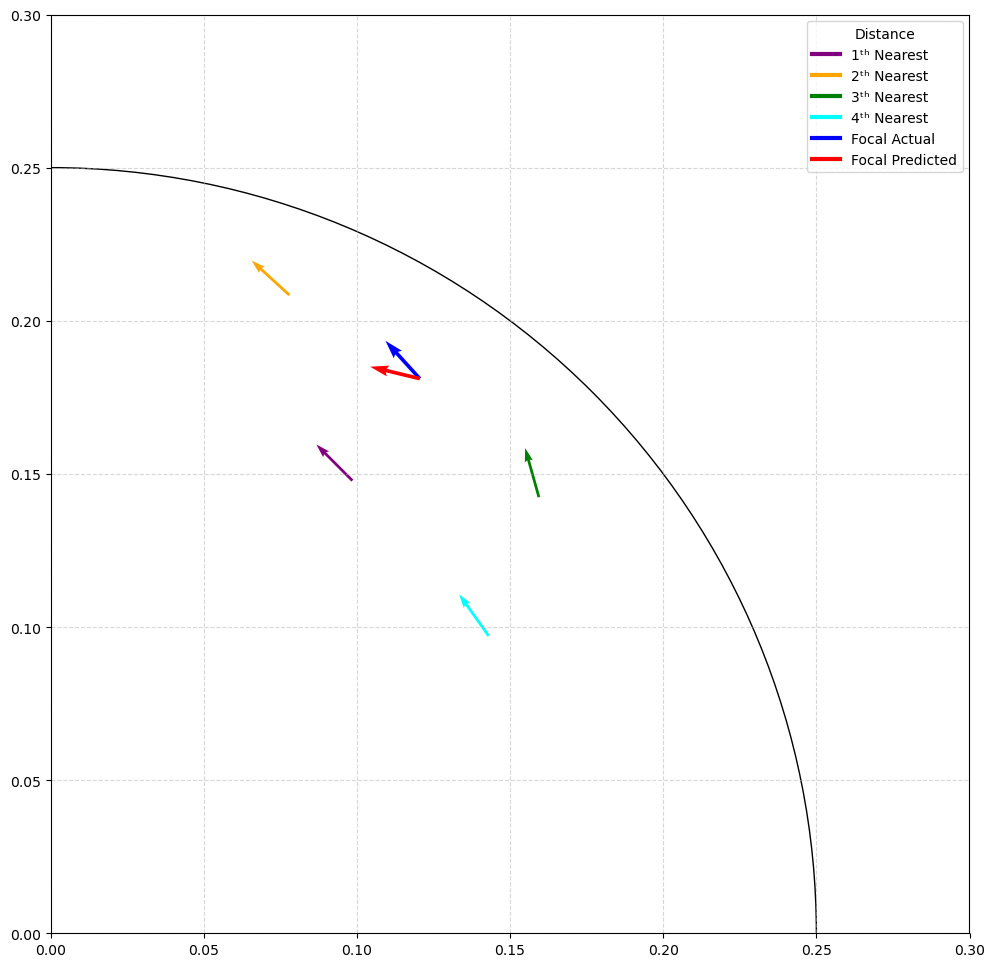

In [50]:
def plot_neighbors_and_focal(load, features_csv, experiment_id, target_kicktime, focal_id=3):

    df = pd.read_csv(features_csv)
    df = df[df['Experiment_ID'] == experiment_id]
    df_step = df[df['Kick_Time'] == target_kicktime].copy()

    # 2) focal position
    focal = df_step[df_step['Agent_ID'] == focal_id].iloc[0]
    fx, fy = focal['X'], focal['Y']

    # 3) Compute neighbor distances & rank
    df_step['dist'] = np.hypot(df_step['X'] - fx, df_step['Y'] - fy)
    neigh = df_step[df_step['Agent_ID'] != focal_id].sort_values('dist').copy()
    # assign rank without comprehension
    ranks = []
    for i in range(len(neigh)):
        ranks.append(i + 1)
    neigh['rank'] = ranks

    # 4) Extract predicted & actual focal velocity
    v_act = None
    v_pred = None
    for rec in load:
        if rec.get('kicktime') == target_kicktime:
            v_act = (rec['actual_vx'], rec['actual_vy'])
            v_pred = (rec['predicted_vx'], rec['predicted_vy'])
            break

    arrow_len = 0.04
    rank_colors = {1: 'purple', 2: 'orange', 3: 'green', 4: 'cyan'}

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.add_patch(Circle((0, 0), 0.25, edgecolor='k', fill=False))

    # 6) Plot neighbor vectors
    for idx in range(len(neigh)):
        row = neigh.iloc[idx]
        x = row['X']; y = row['Y']
        vx = row['vx']; vy = row['vy']
        rank = row['rank']
        norm = np.hypot(vx, vy)
        if norm == 0:
            norm = 1.0
        dx = vx / norm * arrow_len
        dy = vy / norm * arrow_len
        color = rank_colors.get(rank, 'gray')
        ax.quiver(x, y, dx, dy, color=color, width=0.003)

    # 7) Plot focal actual vs predicted
    norm_act = np.hypot(v_act[0], v_act[1])
    if norm_act == 0:
        norm_act = 1.0
    norm_pre = np.hypot(v_pred[0], v_pred[1])
    if norm_pre == 0:
        norm_pre = 1.0
    dax = v_act[0] / norm_act * arrow_len
    day = v_act[1] / norm_act * arrow_len
    px = v_pred[0] / norm_pre * arrow_len
    py = v_pred[1] / norm_pre * arrow_len

    ax.quiver(fx, fy, dax, day, color='blue', width=0.004, label='Focal Actual')
    ax.quiver(fx, fy, px,  py,  color='red',  width=0.004, label='Focal Predicted')

    neigh_handles = []
    neigh_labels = []
    for rank in [1, 2, 3, 4]:
        neigh_handles.append(Line2D([0], [0], color=rank_colors[rank], lw=3))
        neigh_labels.append(f"{rank}ᵗʰ Nearest")

    focal_handles = []
    focal_labels = []
    for color, label in [('blue', 'Focal Actual'), ('red', 'Focal Predicted')]:
        focal_handles.append(Line2D([0], [0], color=color, lw=3))
        focal_labels.append(label)

    ax.legend(
        neigh_handles + focal_handles,
        neigh_labels + focal_labels,
        title="Distance",
        loc='upper right'
    )

    ax.set_aspect('equal')
    ax.set_xlim(0, 0.3)
    ax.set_ylim(0, 0.3)
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    plt.show()
    
plot_neighbors_and_focal(
        load=load,
        features_csv='features.csv',
        experiment_id=151,
        target_kicktime=195.2,
        focal_id=3
    ) 

C:\Users\soori\AppData\Local\Temp\ipykernel_22672\475277940.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left', fontsize=10)


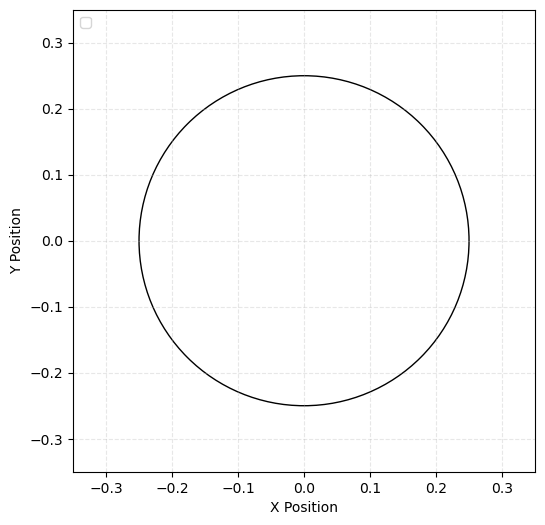

In [ ]:
def plot_wall_zones_with_distance_line(tank_radius=0.25):
    fig, ax = plt.subplots(figsize=(6,6))

    # Tank boundary
    tank = Circle((0,0), tank_radius, edgecolor='black', facecolor='none', linewidth=1)
    ax.add_patch(tank)
    
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-tank_radius - 0.1, tank_radius + 0.1)
    ax.set_ylim(-tank_radius - 0.1, tank_radius + 0.1)
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.3)

    plt.savefig('cooridinate.png')
    plt.savefig('cooridinate.pdf')
    plt.savefig('cooridinate.svg')
plot_wall_zones_with_distance_line()
